In [45]:
# import os
# os.chdir('../../')

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scr.util import *

In [47]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.pipeline import Pipeline

In [48]:
df_train = pd.read_csv('data/null_survey/train_age_income_trips_ok.csv')
df_test = pd.read_csv('data/null_survey/test_age_income_trips_ok.csv')

In [49]:
df_train.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
ProdTaken                   0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [50]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

<Axes: >

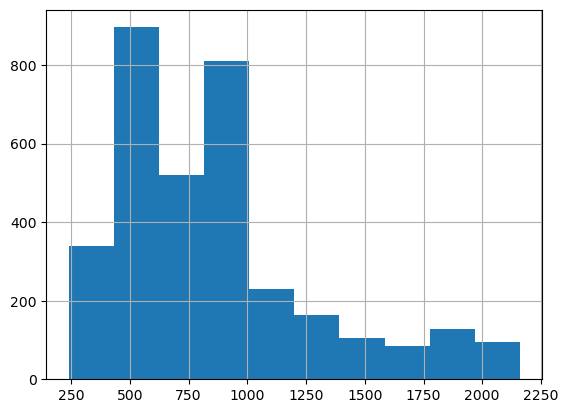

In [51]:
df_train['DurationOfPitch'].hist()

<Axes: >

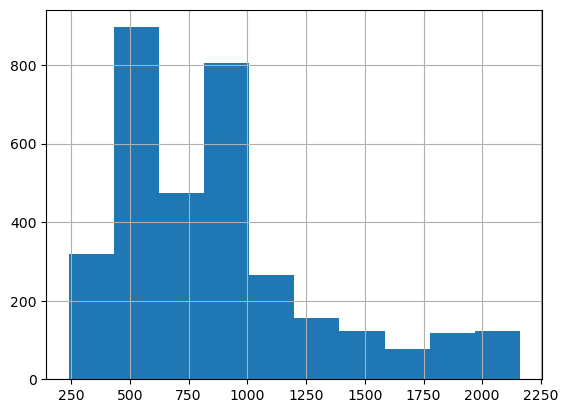

In [52]:
df_test['DurationOfPitch'].hist()

In [53]:
# DurationOfPitch を正規分布に近づける

df_train['DurationOfPitch'] = np.log1p(df_train['DurationOfPitch'])
df_test['DurationOfPitch'] = np.log1p(df_test['DurationOfPitch'])

<Axes: >

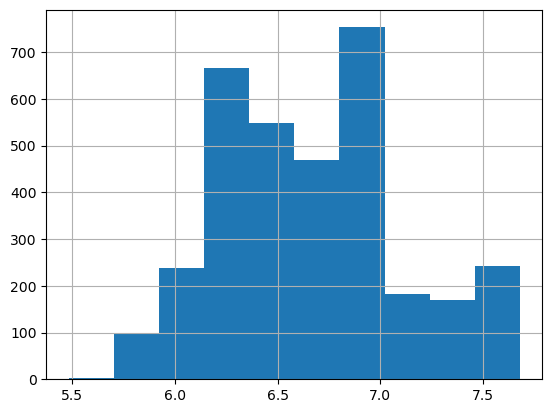

In [54]:
df_train['DurationOfPitch'].hist()

<Axes: >

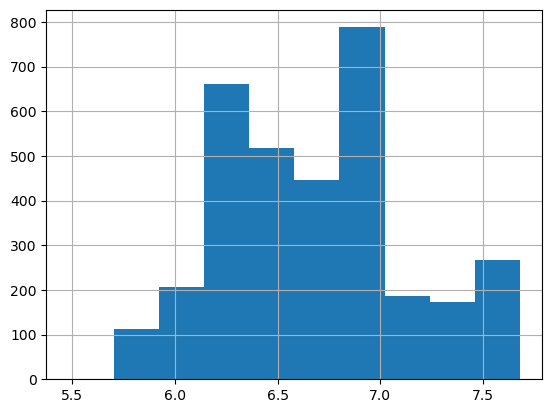

In [55]:
df_test['DurationOfPitch'].hist()

In [56]:
df_train['DurationOfPitch'].isna().sum()

121

In [57]:
df_test['DurationOfPitch'].isna().sum()

131

# 今回調査する欠損値：Age, *DurationOfPitch*, NumberOfTrips, MonthlyIncome

# DurationOfPitch

In [58]:
df_all = pd.concat([df_train, df_test], axis=0)

In [59]:
# DurationOfPitch を予測するための特徴量を選択
predict_duration_feature = ['Age', 'TypeofContact','CityTier','Occupation','Gender','NumberOfPersonVisiting',
                        'NumberOfFollowups','ProductPitched','PreferredPropertyStar','NumberOfTrips' ,'PitchSatisfactionScore', 'Passport','Designation','MonthlyIncome' ,'Marry', 'Car','Child']

# 主キー用idを取得
id_train = df_train.loc[df_train['DurationOfPitch'].isna()].index
id_test = df_test.loc[df_test['DurationOfPitch'].isna()].index

# 目的変数をDurationOfPitchとする
X_train_predict_duration = df_all.loc[~(df_all['DurationOfPitch'].isna()), predict_duration_feature]
X_test_predict_duration = df_all.loc[df_all['DurationOfPitch'].isna(), predict_duration_feature]
y_train_predict_duration = df_all.loc[~(df_all['DurationOfPitch'].isna()), 'DurationOfPitch']
y_test_predict_duration = None

In [60]:
X_train_predict_duration, X_test_predict_duration = mapping_first_category(X_train_predict_duration, X_test_predict_duration)
X_train_predict_duration, X_test_predict_duration = feature_to_int(X_train_predict_duration, X_test_predict_duration)

In [61]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(kf.split(X_train_predict_duration, y_train_predict_duration))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'iterations': 10000,
    'learning_rate': 0.005,
    'depth': 6,
    'l2_leaf_reg': 5,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X_train_predict_duration, y_train_predict_duration, cv_list, params)

0:	learn: 0.4493401	test: 0.4364297	best: 0.4364297 (0)	total: 1.89ms	remaining: 18.9s
100:	learn: 0.4358467	test: 0.4246053	best: 0.4246053 (100)	total: 127ms	remaining: 12.5s
200:	learn: 0.4284020	test: 0.4189160	best: 0.4189160 (200)	total: 263ms	remaining: 12.8s
300:	learn: 0.4237160	test: 0.4162032	best: 0.4162032 (300)	total: 381ms	remaining: 12.3s
400:	learn: 0.4204035	test: 0.4148520	best: 0.4148520 (400)	total: 495ms	remaining: 11.9s
500:	learn: 0.4176965	test: 0.4140273	best: 0.4140273 (500)	total: 609ms	remaining: 11.6s
600:	learn: 0.4154961	test: 0.4134797	best: 0.4134752 (599)	total: 724ms	remaining: 11.3s
700:	learn: 0.4135303	test: 0.4132480	best: 0.4132480 (700)	total: 837ms	remaining: 11.1s
800:	learn: 0.4118002	test: 0.4129850	best: 0.4129846 (799)	total: 960ms	remaining: 11s
900:	learn: 0.4102019	test: 0.4128913	best: 0.4128871 (897)	total: 1.09s	remaining: 11s
1000:	learn: 0.4087467	test: 0.4128301	best: 0.4128180 (975)	total: 1.21s	remaining: 10.9s
1100:	learn: 0.4

In [62]:
y_test_predict_duration = np.zeros(len(X_test_predict_duration))

# アンサンブル
for model in models:
    y_test_predict_duration += model.predict(X_test_predict_duration) / len(models)

y_test_predict_duration = pd.DataFrame({
    'DurationOfPitch': y_test_predict_duration
})

In [63]:
# 訓練データとテストデータに分割する
predicted_train_duration = y_test_predict_duration.iloc[:len(id_train), 0]
predicted_test_duration = y_test_predict_duration.iloc[len(id_train): , 0]

# id(主キー)を与える。
predicted_train_duration.index = id_train
predicted_test_duration.index = id_test

In [64]:
df_train[20:30]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,Marry,Car,Child,AgeGroup
20,20,30,Self Enquiry,1,6.175867,Salaried,male,1.0,3.0,Standard,...,2.0,0,3,Senior Manager,13.028604,0,Single,No Car,0_child,30s
21,21,34,Company Invited,2,6.867974,Salaried,female,1.0,3.0,Basic,...,2.0,0,4,Executive,12.482628,0,Divorced,Has Car,0_child,30s
22,22,29,Company Invited,1,6.175867,Salaried,female,1.0,3.0,Basic,...,1.0,0,3,Executive,12.478867,1,Divorced,No Car,0_child,20s
23,23,56,Company Invited,2,6.803505,Salaried,male,1.0,3.0,Deluxe,...,1.0,0,3,AVP,12.974480,0,Married,Has Car,0_child,50s
24,24,30,Self Enquiry,2,6.867974,Salaried,male,1.0,3.0,Basic,...,2.0,0,4,Executive,12.430320,0,Divorced,Has Car,0_child,30s
25,25,41,Company Invited,2,NaN,Salaried,male,1.0,3.0,Deluxe,...,1.0,0,4,Manager,12.622629,0,Married,No Car,0_child,40s
26,26,39,Self Enquiry,1,NaN,Salaried,female,1.0,3.0,Deluxe,...,1.0,0,4,Manager,12.456232,0,Single,Has Car,0_child,30s
27,27,50,Company Invited,1,6.734592,Salaried,male,1.0,3.0,Standard,...,2.0,0,3,Senior Manager,12.818392,0,Single,Has Car,0_child,50s
28,28,52,Self Enquiry,1,6.928538,Salaried,male,1.0,3.0,Deluxe,...,4.0,0,3,AVP,13.031138,0,Married,Has Car,0_child,50s
29,29,22,Self Enquiry,2,6.398595,Salaried,male,1.0,3.0,Basic,...,1.0,0,4,Executive,12.464143,1,Single,No Car,0_child,20s


In [65]:
df_test[30:40]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
30,3519,33,Self Enquiry,2,6.867974,Salaried,female,1.0,3.0,Basic,4.0,8.0,0,3,Executive,12.506181,Single,No Car,0_child,30s
31,3520,48,Company Invited,2,6.928538,Salaried,female,1.0,3.0,Standard,4.0,5.0,0,3,Senior Manager,12.477038,Married,Has Car,0_child,40s
32,3521,42,Self Enquiry,2,7.039660,Salaried,female,1.0,3.0,Standard,3.0,3.0,0,3,Senior Manager,12.707078,Divorced,No Car,0_child,40s
33,3522,27,Self Enquiry,2,NaN,Salaried,male,1.0,3.0,Basic,3.0,1.0,0,4,Executive,12.431877,Married,No Car,0_child,20s
34,3523,29,Self Enquiry,2,6.175867,Salaried,female,1.0,3.0,Basic,3.0,4.0,0,4,Executive,12.451842,Divorced,Has Car,0_child,20s
35,3524,33,Company Invited,2,6.734592,Salaried,male,1.0,3.0,Basic,3.0,8.0,0,4,Executive,12.458099,Married,Has Car,0_child,30s
36,3525,59,Self Enquiry,1,6.175867,Salaried,male,1.0,3.0,Standard,3.0,4.0,0,4,Senior Manager,12.985996,Married,Has Car,0_child,50s
37,3526,35,Company Invited,1,NaN,Salaried,female,1.0,3.0,Deluxe,3.0,1.0,0,4,Executive,12.399400,Single,Has Car,0_child,30s
38,3527,32,Company Invited,2,6.175867,Salaried,female,1.0,3.0,Standard,3.0,3.0,1,4,Senior Manager,12.854643,Married,No Car,0_child,30s
39,3528,50,Self Enquiry,1,6.398595,Salaried,male,2.0,3.0,King,4.0,6.0,0,5,VP,13.124034,Single,Has Car,0_child,50s


In [66]:
# 欠損値を予測値で補完する
df_train.loc[df_train['DurationOfPitch'].isna(), 'DurationOfPitch'] = round(predicted_train_duration)
df_test.loc[df_test['DurationOfPitch'].isna(), 'DurationOfPitch'] = round(predicted_test_duration)

In [67]:
df_train[20:30]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,Marry,Car,Child,AgeGroup
20,20,30,Self Enquiry,1,6.175867,Salaried,male,1.0,3.0,Standard,...,2.0,0,3,Senior Manager,13.028604,0,Single,No Car,0_child,30s
21,21,34,Company Invited,2,6.867974,Salaried,female,1.0,3.0,Basic,...,2.0,0,4,Executive,12.482628,0,Divorced,Has Car,0_child,30s
22,22,29,Company Invited,1,6.175867,Salaried,female,1.0,3.0,Basic,...,1.0,0,3,Executive,12.478867,1,Divorced,No Car,0_child,20s
23,23,56,Company Invited,2,6.803505,Salaried,male,1.0,3.0,Deluxe,...,1.0,0,3,AVP,12.974480,0,Married,Has Car,0_child,50s
24,24,30,Self Enquiry,2,6.867974,Salaried,male,1.0,3.0,Basic,...,2.0,0,4,Executive,12.430320,0,Divorced,Has Car,0_child,30s
25,25,41,Company Invited,2,7.000000,Salaried,male,1.0,3.0,Deluxe,...,1.0,0,4,Manager,12.622629,0,Married,No Car,0_child,40s
26,26,39,Self Enquiry,1,7.000000,Salaried,female,1.0,3.0,Deluxe,...,1.0,0,4,Manager,12.456232,0,Single,Has Car,0_child,30s
27,27,50,Company Invited,1,6.734592,Salaried,male,1.0,3.0,Standard,...,2.0,0,3,Senior Manager,12.818392,0,Single,Has Car,0_child,50s
28,28,52,Self Enquiry,1,6.928538,Salaried,male,1.0,3.0,Deluxe,...,4.0,0,3,AVP,13.031138,0,Married,Has Car,0_child,50s
29,29,22,Self Enquiry,2,6.398595,Salaried,male,1.0,3.0,Basic,...,1.0,0,4,Executive,12.464143,1,Single,No Car,0_child,20s


In [68]:
df_test[30:40]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
30,3519,33,Self Enquiry,2,6.867974,Salaried,female,1.0,3.0,Basic,4.0,8.0,0,3,Executive,12.506181,Single,No Car,0_child,30s
31,3520,48,Company Invited,2,6.928538,Salaried,female,1.0,3.0,Standard,4.0,5.0,0,3,Senior Manager,12.477038,Married,Has Car,0_child,40s
32,3521,42,Self Enquiry,2,7.039660,Salaried,female,1.0,3.0,Standard,3.0,3.0,0,3,Senior Manager,12.707078,Divorced,No Car,0_child,40s
33,3522,27,Self Enquiry,2,7.000000,Salaried,male,1.0,3.0,Basic,3.0,1.0,0,4,Executive,12.431877,Married,No Car,0_child,20s
34,3523,29,Self Enquiry,2,6.175867,Salaried,female,1.0,3.0,Basic,3.0,4.0,0,4,Executive,12.451842,Divorced,Has Car,0_child,20s
35,3524,33,Company Invited,2,6.734592,Salaried,male,1.0,3.0,Basic,3.0,8.0,0,4,Executive,12.458099,Married,Has Car,0_child,30s
36,3525,59,Self Enquiry,1,6.175867,Salaried,male,1.0,3.0,Standard,3.0,4.0,0,4,Senior Manager,12.985996,Married,Has Car,0_child,50s
37,3526,35,Company Invited,1,7.000000,Salaried,female,1.0,3.0,Deluxe,3.0,1.0,0,4,Executive,12.399400,Single,Has Car,0_child,30s
38,3527,32,Company Invited,2,6.175867,Salaried,female,1.0,3.0,Standard,3.0,3.0,1,4,Senior Manager,12.854643,Married,No Car,0_child,30s
39,3528,50,Self Enquiry,1,6.398595,Salaried,male,2.0,3.0,King,4.0,6.0,0,5,VP,13.124034,Single,Has Car,0_child,50s


In [69]:
df_train.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [70]:
df_test.isna().sum()

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
Marry                     0
Car                       0
Child                     0
AgeGroup                  0
dtype: int64

In [71]:
df_train.to_csv('data/null_survey/train_all_ok.csv', index=False)
df_test.to_csv('data/null_survey/test_all_ok.csv', index=False)